<a href="https://colab.research.google.com/github/zhangs22/radioml_edge_training/blob/main/rml_training_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
import pickle, random
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("/content/drive/My Drive/Colab Notebooks/RML2016.10a/RML2016.10a_dict.pkl",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
print(type(X), X.shape)
print(len(mods), mods)
print(len(snrs), snrs)

<class 'numpy.ndarray'> (220000, 2, 128, 1)
11 ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
20 [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [139]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.8)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [140]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
print(X_test.shape)
classes = mods

(176000, 2, 128, 1) [2, 128, 1]
(44000, 2, 128, 1)


In [141]:
dr = 0.5 # dropout rate (%)
adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = SGD(learning_rate=0.01, momentum=0.9)
model = keras.Sequential()
model.add(layers.Input(in_shp))
model.add(layers.ZeroPadding2D((3, 1)))
model.add(layers.Conv2D(16, kernel_size=(3, 3), padding="valid", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(1, 2), strides=2, padding="valid"))
model.add(layers.ZeroPadding2D(padding=((3, 2), (1, 1))))
model.add(layers.Conv2D(32, kernel_size=(3, 3), padding="valid", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(1, 2), strides=2, padding="valid"))
model.add(layers.ZeroPadding2D(padding=((3, 2), (1, 1))))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding="valid", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(6, 2), strides=2, padding="valid"))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(len(classes), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer=adm, metrics=["accuracy"])
model.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_127 (ZeroPad  (None, 8, 130, 1)        0         
 ding2D)                                                         
                                                                 
 conv2d_140 (Conv2D)         (None, 6, 128, 16)        160       
                                                                 
 max_pooling2d_117 (MaxPooli  (None, 3, 64, 16)        0         
 ng2D)                                                           
                                                                 
 zero_padding2d_128 (ZeroPad  (None, 8, 66, 16)        0         
 ding2D)                                                         
                                                                 
 conv2d_141 (Conv2D)         (None, 6, 64, 32)         4640      
                                                     

In [142]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [143]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
history = model.fit(X_train, Y_train, batch_size=batch_size, verbose=2, epochs=nb_epoch, validation_split=0.1)

Epoch 1/100
155/155 - 6s - loss: 2.2490 - accuracy: 0.1677 - val_loss: 2.0891 - val_accuracy: 0.2374 - 6s/epoch - 39ms/step
Epoch 2/100
155/155 - 4s - loss: 1.9421 - accuracy: 0.2853 - val_loss: 1.8258 - val_accuracy: 0.3232 - 4s/epoch - 26ms/step
Epoch 3/100
155/155 - 4s - loss: 1.7784 - accuracy: 0.3352 - val_loss: 1.7525 - val_accuracy: 0.3382 - 4s/epoch - 26ms/step
Epoch 4/100
155/155 - 4s - loss: 1.7242 - accuracy: 0.3531 - val_loss: 1.7165 - val_accuracy: 0.3546 - 4s/epoch - 26ms/step
Epoch 5/100
155/155 - 4s - loss: 1.6850 - accuracy: 0.3749 - val_loss: 1.6642 - val_accuracy: 0.3814 - 4s/epoch - 27ms/step
Epoch 6/100
155/155 - 4s - loss: 1.6258 - accuracy: 0.4005 - val_loss: 1.6101 - val_accuracy: 0.4066 - 4s/epoch - 27ms/step
Epoch 7/100
155/155 - 4s - loss: 1.5791 - accuracy: 0.4173 - val_loss: 1.5879 - val_accuracy: 0.4125 - 4s/epoch - 28ms/step
Epoch 8/100
155/155 - 4s - loss: 1.5431 - accuracy: 0.4322 - val_loss: 1.5382 - val_accuracy: 0.4350 - 4s/epoch - 28ms/step
Epoch 9/

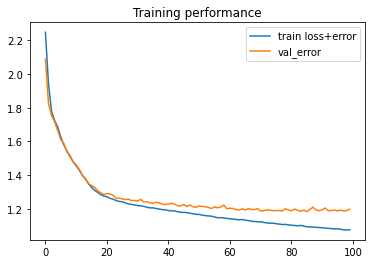

In [144]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [145]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1932320594787598
Test accuracy: 0.5499091148376465


In [146]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

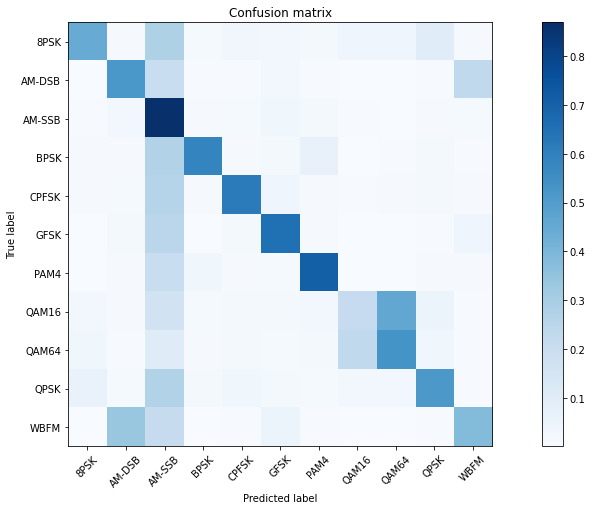

In [147]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.rcParams['figure.figsize'] = [14, 7]
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.09115523465703972
Overall Accuracy:  0.08851566046300499
Overall Accuracy:  0.09621523027815777
Overall Accuracy:  0.13005514705882354
Overall Accuracy:  0.16898251904975348
Overall Accuracy:  0.2583041958041958
Overall Accuracy:  0.3661904761904762
Overall Accuracy:  0.4813650651100135
Overall Accuracy:  0.6042654028436019
Overall Accuracy:  0.684931506849315
Overall Accuracy:  0.748995087092452
Overall Accuracy:  0.790009250693802
Overall Accuracy:  0.798442510306917
Overall Accuracy:  0.8157415832575068
Overall Accuracy:  0.8100863243980009
Overall Accuracy:  0.8170289855072463
Overall Accuracy:  0.8166591217745586
Overall Accuracy:  0.8202508128193219
Overall Accuracy:  0.8119307832422586
Overall Accuracy:  0.8070409982174688


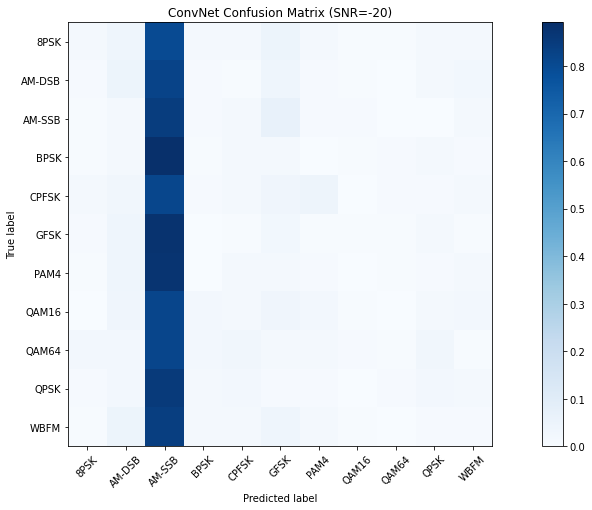

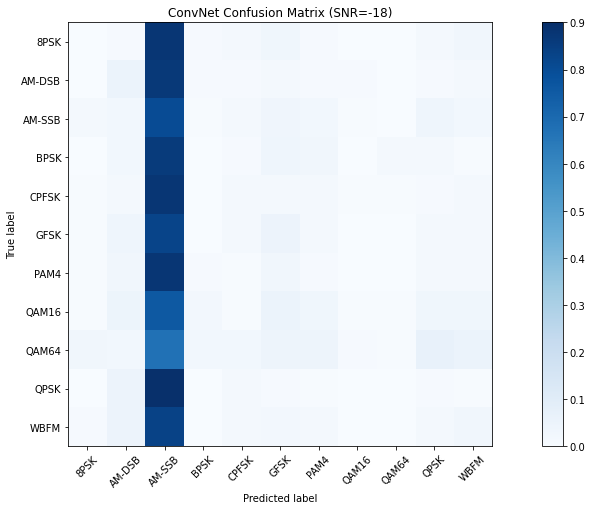

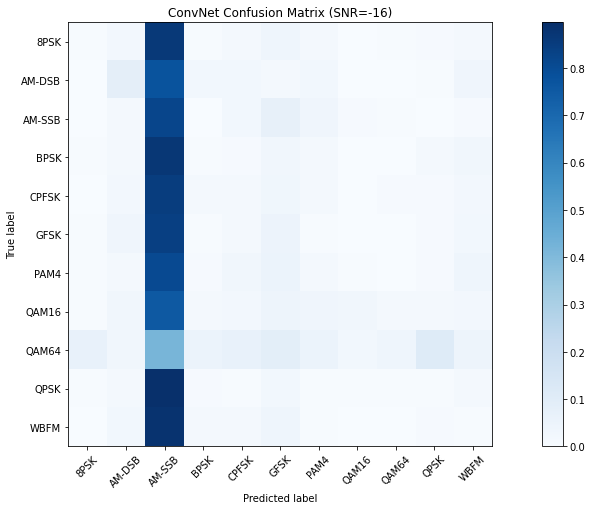

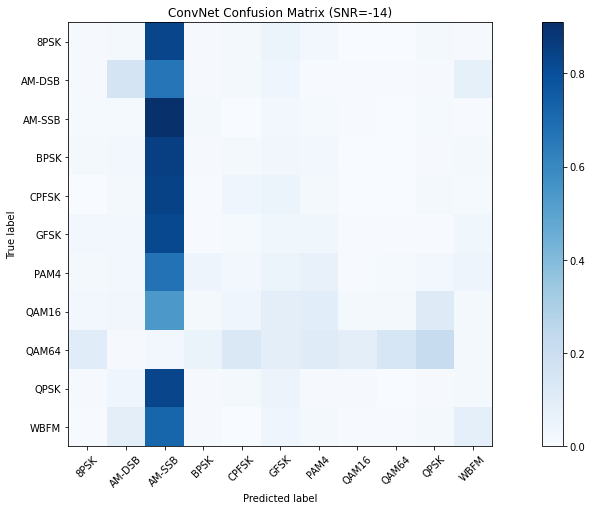

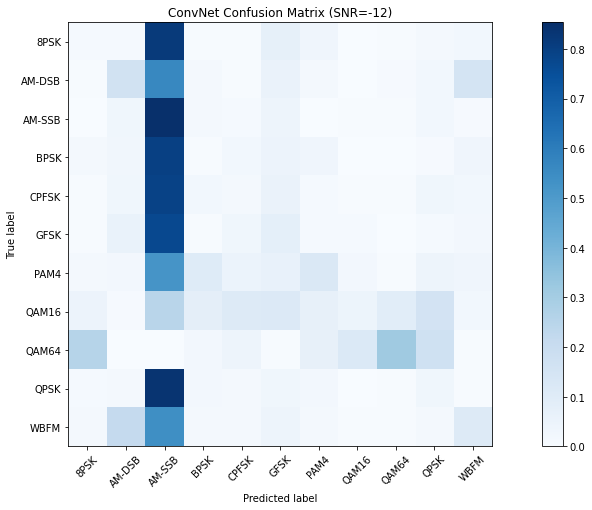

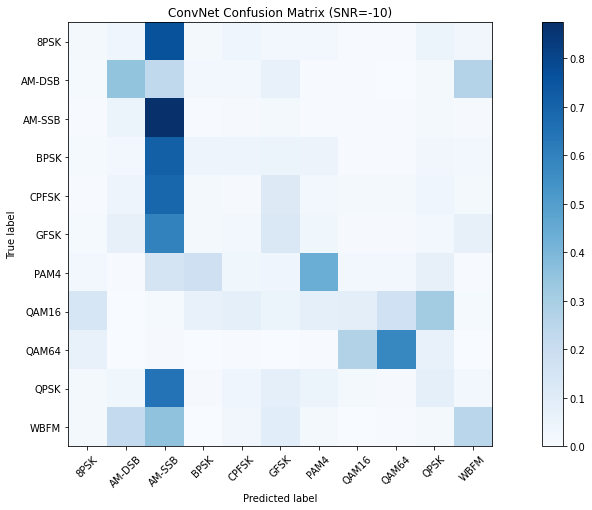

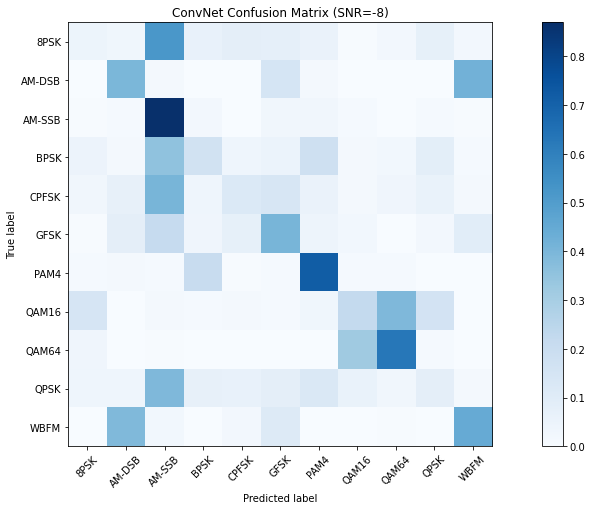

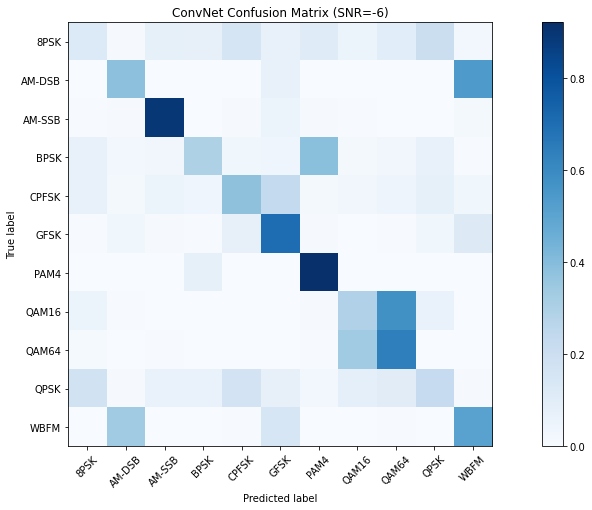

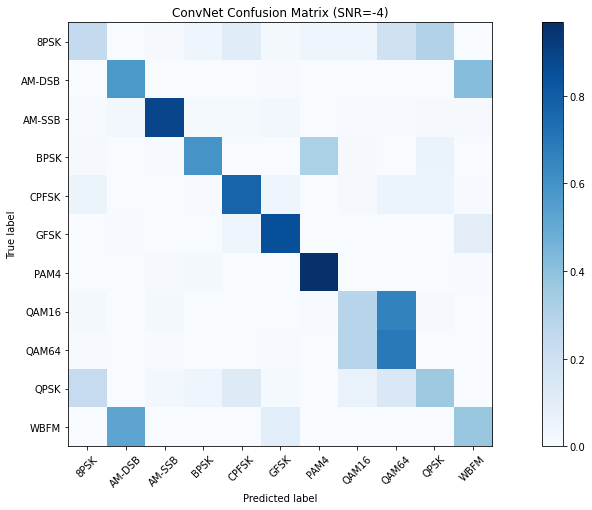

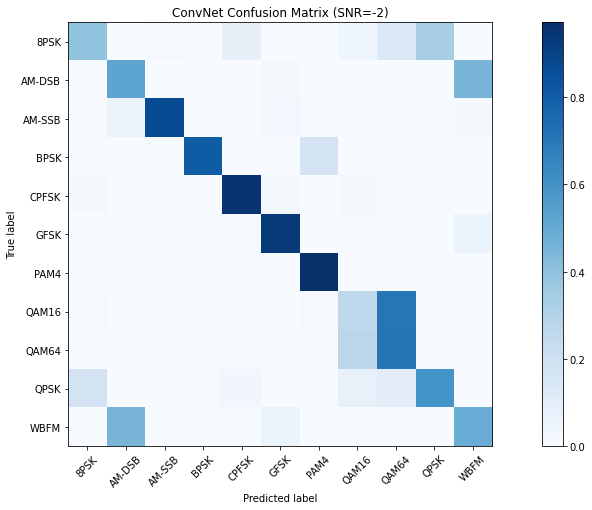

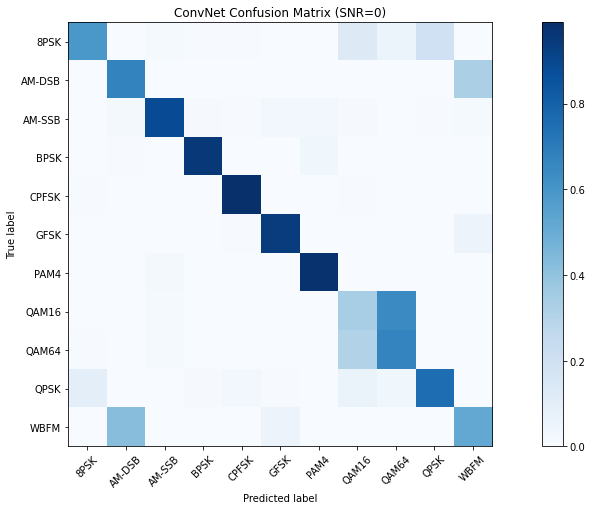

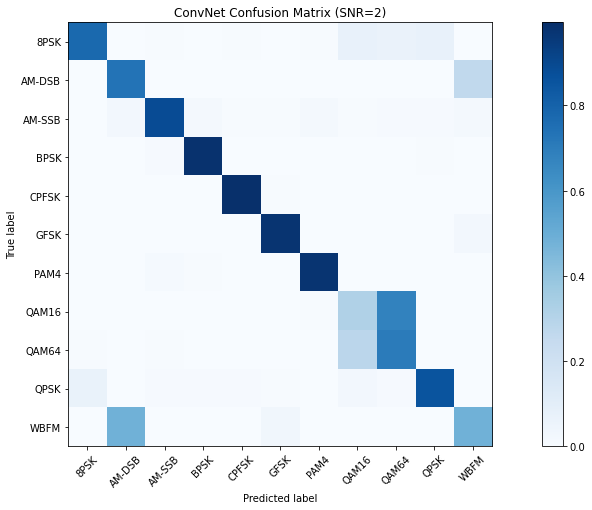

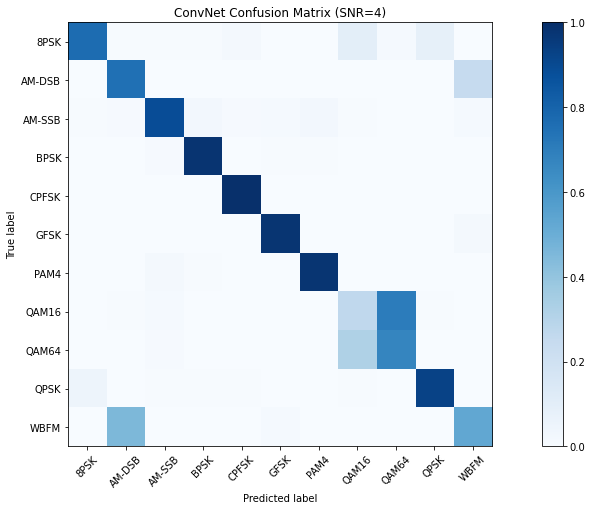

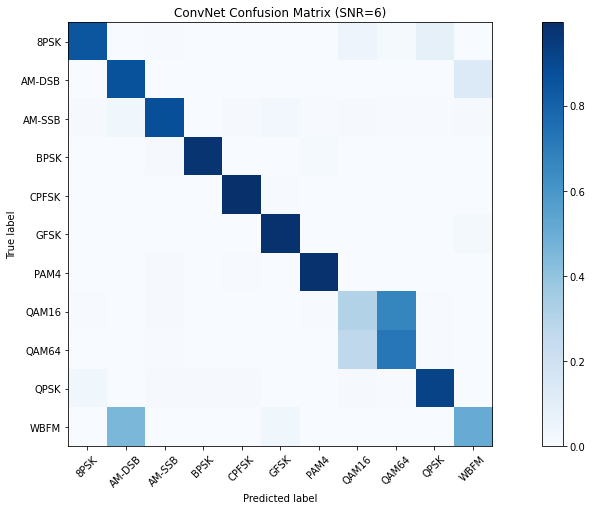

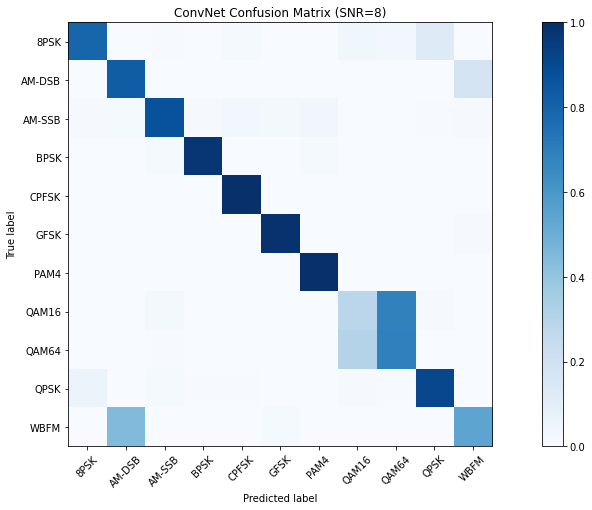

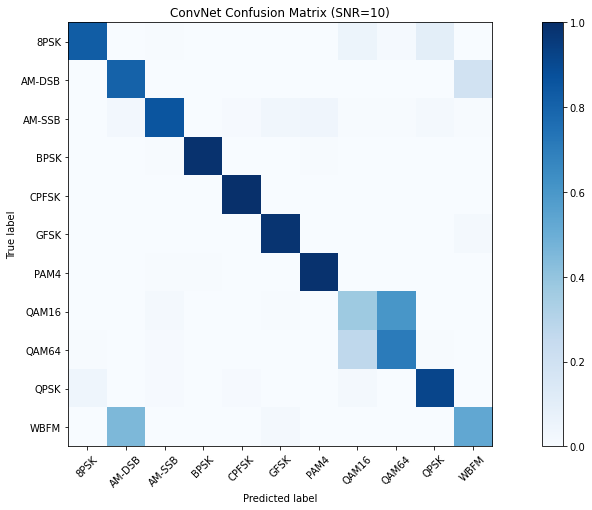

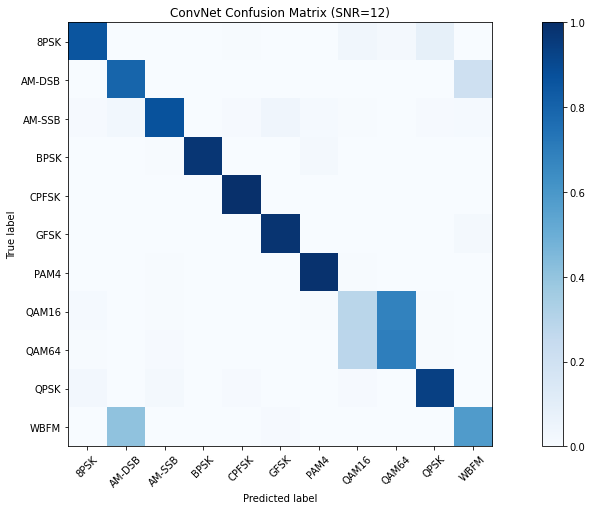

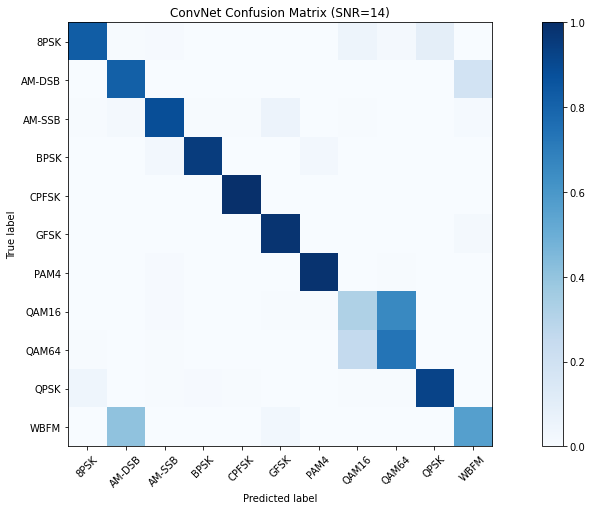

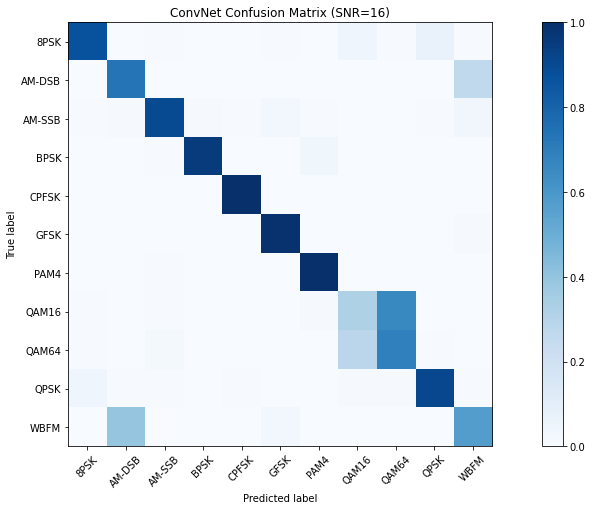

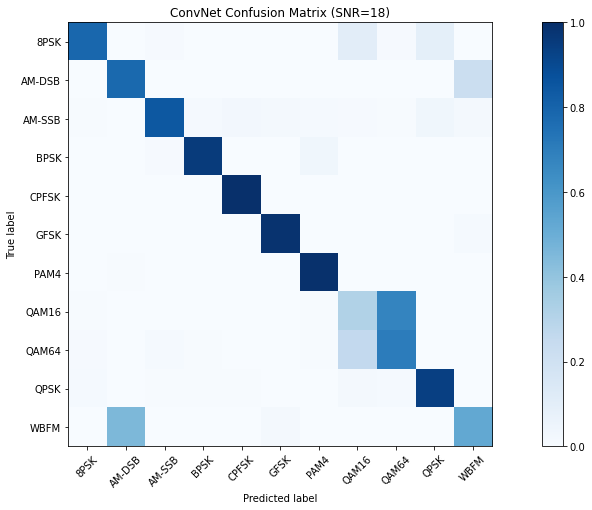

In [148]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

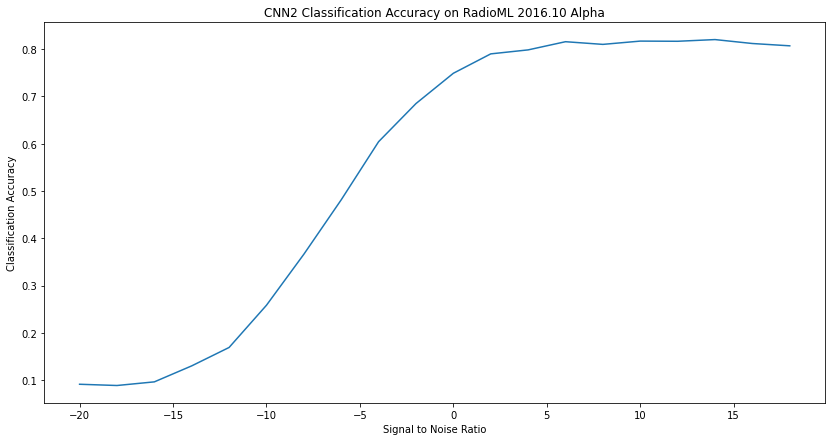

In [149]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")